# Proyek Klasifikasi Gambar: Garbage Classification

- **Nama:** Duma Mora Arta Sitorus
- **Email:** dumamora5@gmail.com
- **ID Dicoding:** duma_mora

**Deskripsi Proyek:**
  
  Proyek ini bertujuan untuk menghasilkan model yang dapat melakukan klasifikasi terhadap data gambar berdasarkan jenis sampah.


---


**Dataset**

  Dataset yang digunakan merupakan data gambar sampah yang dibagi kedalam beberapa subfolder bernama setiap label berupa jenis sampah tersebut.
  Dataset ini terdiri atas 15,150 gambar dari 12 kelas yang berbeda berdasarkan jenis sampah rumah, antara lain:

1.   battery (sampah baterai)
2.   biological (sampah biologis)
3.   brown-glass (sampah kaca berwarna cokelat)
4.   cardboard (sampah kardus)
5.   clothes (sampah pakaian)
6.   green-glass (sampah kaca berwarna hijau)
7.   metal (sampah berahan metal)
8.   paper (sampah kertas)
9.   plastic (sampah plastik)
10.  shoes (sampah sepatu)
11.  trash (sampah seperti popok, masker, sikat gigi dan lain-lain)
12.  white-glass (sampah kaca berwarna bening)


---


**Sumber Dataset**
  
  Dataset ini diperoleh dari platform penyedia dataset [Kaggle](https://www.kaggle.com/)

  Dataset:  [Garbage Classification (12 classes)](https://www.kaggle.com/datasets/mostafaabla/garbage-classification)

## Import Semua Packages/Library yang Digunakan

In [88]:
import shutil
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import kagglehub
import io
import pandas as pd
import seaborn as sns

from collections import defaultdict, Counter
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflowjs as tfjs

## Data Preparation

Tahapan Data Preparation terdiri dari:
1.   Data Loading : proses ini dilakukan dengan mendownload dataset dari sumber public repository dataset yaitu Kaggle  yang dapat diakses melalui tautan berikut: https://www.kaggle.com/datasets/mostafaabla/garbage-classification/data

2.   Eksplorasi Data : Proses ini berguna untuk menambah pengetahuan kita mengenai data set yang digunakan. Ekplorasi dilakukan dengan mencari tahu letak folder, jumlah dan resolusi unik gambar di setiap label

3.   Visualisasi Data : Proses ini berguna untuk menambah pengetahuan kita melalui visualisasi dari data set yang dimiliki

### Data Loading

In [3]:
# download dataset menggunakan API dari kagle
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification


### Eksplorasi Data

In [4]:
# menampilkan path dataset yang telah diunduh ke direktori
import pathlib
dataset_path = pathlib.Path(path)
for item in dataset_path.iterdir():
    print(item)

/kaggle/input/garbage-classification/garbage_classification


In [5]:
# menghitung jumlah data & resolusi data dalam dataset
dataset_path = "/kaggle/input/garbage-classification/garbage_classification"

# inisialisasi variabel penampung
label_counts = defaultdict(int)
resolution_counter = Counter()
resolution_per_label = defaultdict(set)

# loop menghitung jumlah data & resolusi data dalam dataset
for label in os.listdir(dataset_path):
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    label_counts[label] += 1
                    resolution = img.size  # (width, height)
                    resolution_counter[resolution] += 1
                    resolution_per_label[label].add(resolution)
            except Exception as e:
                print(f"Gagal membuka {img_path}: {e}")

In [6]:
# print jumlah gambar per label
print("Jumlah gambar per label:")
for label, count in label_counts.items():
    print(f"{label}: {count} gambar")



Jumlah gambar per label:
metal: 769 gambar
white-glass: 775 gambar
biological: 985 gambar
paper: 1050 gambar
brown-glass: 607 gambar
battery: 945 gambar
trash: 697 gambar
cardboard: 891 gambar
shoes: 1977 gambar
clothes: 5325 gambar
plastic: 865 gambar
green-glass: 629 gambar


In [7]:
# print resolusi unik per label
print("\nResolusi berbeda-beda per label:")
for label, resolutions in resolution_per_label.items():
    print(f"{label}: {list(resolutions)}\n")


Resolusi berbeda-beda per label:
metal: [(225, 224), (200, 252), (363, 139), (201, 251), (223, 226), (220, 218), (276, 183), (150, 150), (199, 253), (259, 194), (180, 157), (347, 145), (266, 190), (272, 185), (258, 195), (287, 176), (247, 204), (270, 187), (339, 149), (256, 197), (262, 192), (245, 206), (291, 173), (246, 205), (251, 201), (306, 164), (309, 163), (349, 144), (298, 169), (260, 194), (249, 203), (250, 202), (233, 216), (180, 180), (234, 215), (293, 172), (318, 159), (248, 204), (232, 217), (235, 215), (236, 214), (310, 163), (224, 224), (271, 186), (276, 182), (220, 229), (225, 225), (275, 183), (261, 193), (174, 289), (266, 189), (287, 175), (250, 199), (265, 190), (294, 171), (297, 170), (254, 199), (285, 177), (286, 176), (184, 275), (277, 182), (269, 187), (311, 162), (280, 156), (300, 168), (243, 207), (306, 165), (307, 164), (207, 244), (208, 243), (228, 221), (236, 213), (227, 222), (200, 253), (278, 181), (477, 106), (189, 231), (259, 195), (512, 384), (217, 232)

### Visualisasi Data

In [8]:
# buat DataFrame untuk dataset

image_paths = []
labels = []

# loop seluruh folder label dan gambar
for label in os.listdir(dataset_path):
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):  # validasi file gambar
                image_paths.append(img_path)
                labels.append(label)


df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

<ipython-input-9-9485339bf5c2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='viridis')


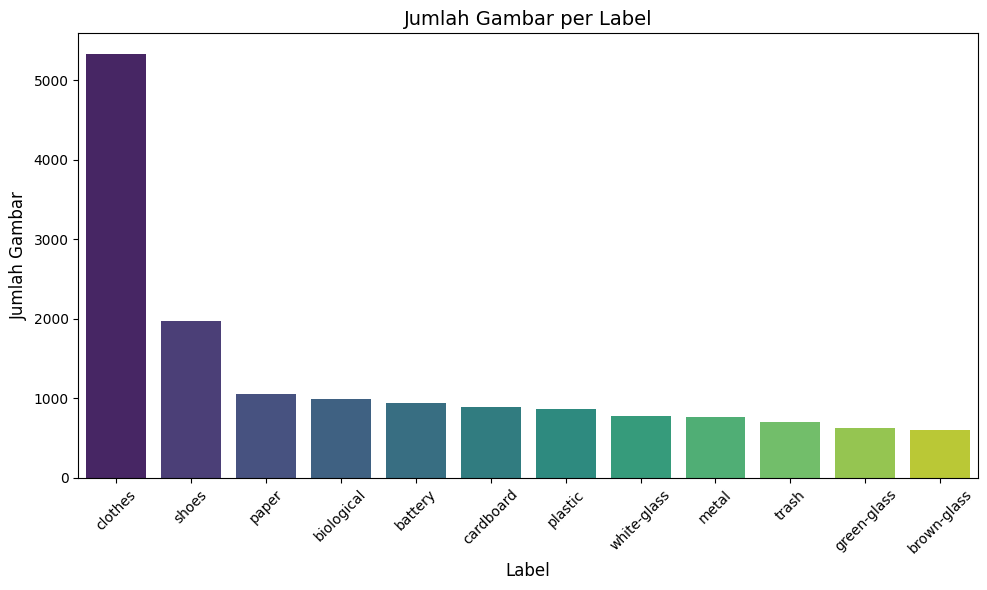

In [9]:
# visualisasi berupa grafik jumlah gambar per label
plt.figure(figsize=(10, 6))

# diagram batang
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='viridis')

# plot
plt.title('Jumlah Gambar per Label', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

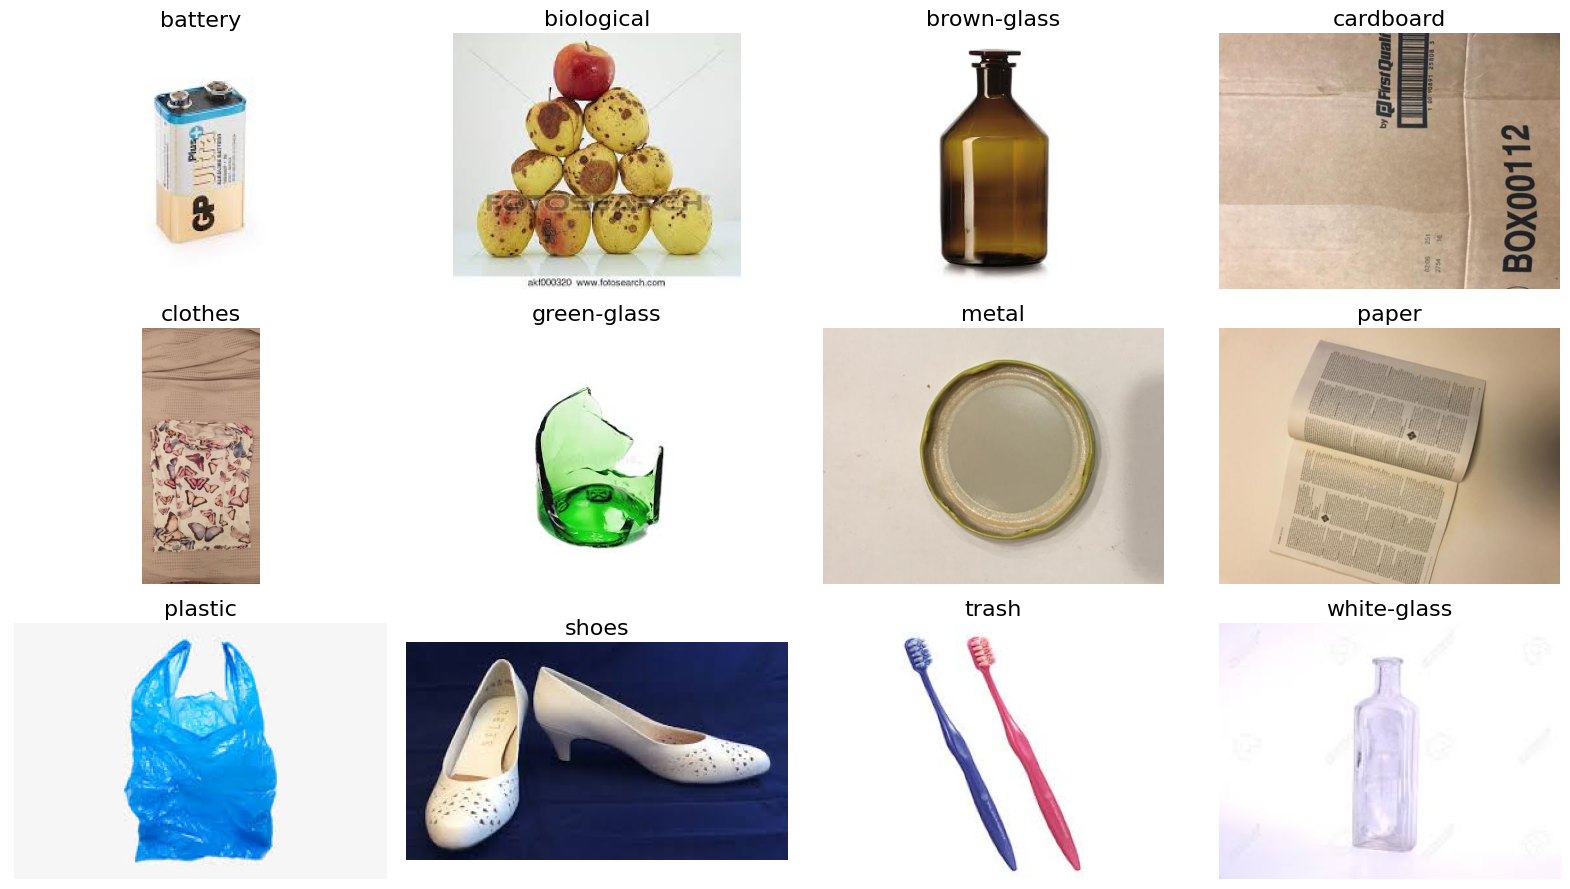

In [10]:
# Menampilkan satu sampel data per label
sample_images = df.groupby('label').first().reset_index()
num_labels = len(sample_images)

# plot
plt.figure(figsize=(16, 9))
rows, cols = 3, 4

# loop untuk menapilkan gambar
for i, row in sample_images.iterrows():
    img = Image.open(row['image_path'])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(row['label'], fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Data Preprocessing

Tahapan Data Preprocessing terdiri dari:
1.   Pembuatan Direktori data splitting : proses ini dilakukan dengan membuat folder untuk menyimpan hasil splitting di `/kaggle/working/dataset_split`

2.   Data Splitting : Proses ini
dilakukan dengan membagi data menjadi 3 yaitu train, val, dan test data. dengan persentase 90% data train, 7% data val, dan 3% data test untuk masing-masing label.

3. Augmentasi Data : Proses ini berguna untuk menambah variasi data train dan test. Data test hanya dikenakan augmentasi berupa normalisasi dari nilai pixel 0-255 menjadi 0-1. Sedangkan data latih (train) dikenakan augmentasi antara lain normaliasasi, translasi, rotasi, zoom, flip, pengaturan kecerahan.

#### Split Dataset

In [11]:
# Path ke dataset asli (read-only)
main_path = "/kaggle/input/garbage-classification/garbage_classification"

# Path untuk menyimpan hasil split dataset (bisa write)
dataset_path = "/kaggle/working/dataset_split"

In [12]:
# Path baru untuk dataset split
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

In [13]:
# Membuat folder train/val/test jika belum ada
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

In [14]:
# Ambil daftar nama kelas dari folder garbage_classification
classes = [d for d in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, d))]
print("Kelas ditemukan:", classes)

Kelas ditemukan: ['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


In [15]:
# Buat folder train/val/test untuk setiap label
for cls in classes:
    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

In [16]:
# Fungsi aman untuk split dataset
def safe_train_test_split(images, test_size, stratify_labels=None):
    if stratify_labels is not None and len(set(stratify_labels)) > 1:
        return train_test_split(images, test_size=test_size, stratify=stratify_labels, random_state=42)
    else:
        return train_test_split(images, test_size=test_size, random_state=42, shuffle=True)

In [17]:
# Fungsi memindahkan file
def move_images(image_list, src_dir, dst_dir):
    if len(os.listdir(dst_dir)) == 0:  # Hanya jika belum ada data
        for img in image_list:
            shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, img))
        print(f"✅ {len(image_list)} gambar disalin ke {dst_dir}")
    else:
        print(f"⚠ Data sudah ada di {dst_dir}, tidak disalin ulang.")


In [18]:
# Mulai proses split dan salin file
for cls in classes:
    class_path = os.path.join(main_path, cls)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(images) < 2:
        print(f"❌ Lewati '{cls}', karena hanya ada {len(images)} gambar")
        continue

    labels = [cls] * len(images)

    train_images, temp_images = safe_train_test_split(images, test_size=0.10, stratify_labels=labels)
    val_images, test_images = safe_train_test_split(temp_images, test_size=0.30, stratify_labels=[cls] * len(temp_images))

    move_images(train_images, class_path, os.path.join(train_dir, cls))
    move_images(val_images, class_path, os.path.join(val_dir, cls))
    move_images(test_images, class_path, os.path.join(test_dir, cls))

    print("-" * 50)

✅ 692 gambar disalin ke /kaggle/working/dataset_split/train/metal
✅ 53 gambar disalin ke /kaggle/working/dataset_split/val/metal
✅ 24 gambar disalin ke /kaggle/working/dataset_split/test/metal
--------------------------------------------------
✅ 697 gambar disalin ke /kaggle/working/dataset_split/train/white-glass
✅ 54 gambar disalin ke /kaggle/working/dataset_split/val/white-glass
✅ 24 gambar disalin ke /kaggle/working/dataset_split/test/white-glass
--------------------------------------------------
✅ 886 gambar disalin ke /kaggle/working/dataset_split/train/biological
✅ 69 gambar disalin ke /kaggle/working/dataset_split/val/biological
✅ 30 gambar disalin ke /kaggle/working/dataset_split/test/biological
--------------------------------------------------
✅ 945 gambar disalin ke /kaggle/working/dataset_split/train/paper
✅ 73 gambar disalin ke /kaggle/working/dataset_split/val/paper
✅ 32 gambar disalin ke /kaggle/working/dataset_split/test/paper
------------------------------------------

In [19]:
# Fungsi menghitung jumlah gambar
def count_image_subfolders(directory):
    count_per_label = {}
    total = 0
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            count_per_label[label] = num_images
            total += num_images
    return count_per_label, total

In [20]:
# Hitung semua
train_counts, train_total = count_image_subfolders(train_dir)
val_counts, val_total = count_image_subfolders(val_dir)
test_counts, test_total = count_image_subfolders(test_dir)

print("Train Data per Label:", train_counts)
print("Total Train Images:", train_total)

print("\nValidation Data per Label:", val_counts)
print("Total Validation Images:", val_total)

print("\nTest Data per Label:", test_counts)
print("Total Test Images:", test_total)

Train Data per Label: {'battery': 850, 'white-glass': 697, 'cardboard': 801, 'biological': 886, 'brown-glass': 546, 'green-glass': 566, 'trash': 627, 'clothes': 4792, 'shoes': 1779, 'metal': 692, 'plastic': 778, 'paper': 945}
Total Train Images: 13959

Validation Data per Label: {'battery': 66, 'white-glass': 54, 'cardboard': 63, 'biological': 69, 'brown-glass': 42, 'green-glass': 44, 'trash': 49, 'clothes': 373, 'shoes': 138, 'metal': 53, 'plastic': 60, 'paper': 73}
Total Validation Images: 1084

Test Data per Label: {'battery': 29, 'white-glass': 24, 'cardboard': 27, 'biological': 30, 'brown-glass': 19, 'green-glass': 19, 'trash': 21, 'clothes': 160, 'shoes': 60, 'metal': 24, 'plastic': 27, 'paper': 32}
Total Test Images: 472


#### Data Augmentasi

Data aumentasi yang dilakukan pada data gambar meliputi:
  *   Normaliasai dengan mengubah nilai pixel dari 0–255 menjadi 0–1. `(rescale=1./255)`
  *   Rotasi gambar secara acak maksimal ±20 derajat. `(rotation_range=20)`
  *   Menggeser gambar secara horizontal hingga 20% dari lebar gambar `(width_shift_range=0.2)`
  *   Menggeser gambar secara vertikal hingga 20% dari tinggi gambar.`(height_shift_range=0.2)`
  *   Melakukan geser miring, mengubah sudut gambar. `(shear_range=0.15)`
  *   Memperbesar atau memperkecil gambar secara acak hingga 20%. `(zoom_range=0.2)`
  *   Membalik gambar secara horizontal (seperti melihat di cermin). `(horizontal_flip=True)`
  *   Mengubah tingkat kecerahan gambar antara 80%–120% dari aslinya. `(brightness_range=[0.8,1.2])`
  *   Saat augmentasi menyebabkan ada ruang kosong karena dikenakan rotasi atau shift, bagian kosong diisi berdasarkan pixel terdekat. `(fill_mode='nearest')`

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# Ukuran gambar (bisa disesuaikan)
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 13959 images belonging to 12 classes.
Found 1084 images belonging to 12 classes.
Found 472 images belonging to 12 classes.


## Modelling

Tahapan ini berguna untuk melakukan modelling atau menghasilkan model yang telah dilatih dan mampu melakukan klasifikasi pada gambar sampah untuk menentukan jenisnya. Proses pada tahap modelling antara lain:


1.   **Cek Ketersediaan GPU:** Tahapan ini berguna memastikan proses pelatihan model lebih cepat dengan cepat dengan memanfaatkan perangkat pemroses GPU.
2.  **Membuat callback:** Tahapan ini berguna untuk membuat konfigurasi callback guna mengontrol jalannya proses pelatihan. Callback yang digunakan antara lain:
  *   *EarlyStopping* : Menghantikan pelatihan jika akurasi tidak menunjukkan peningkatan pada 3 poch terakhir. Ini membantu dalam menccegar terjadinya overfittinh dan mempersingkat waktu pelatihan jika tidak ada peningkatan akurasi lagi selama proses pelatihan model.
  *   *ModelCheckpoint* : Menyimpan model terbaik yaitu yang memiliki akurasi validasi terbaik. model terbaik disimpan dalam format .h5 sehingga dapat digunakan kembali setelah pelatihan selesai.
  *   *ReduceLROnPlateau*: Menurunkan learning rate jika model tidak menunjukkan peningkatan pada akurasi validasi. Ini berguna untuk memberikan model kesempatan untuk belajar lebih halus di akhir pelatihan dengan memperkecil lompatan pada setiap iterasi.

2.   **Training model:** Tahapan ini berguna melatih model dengan Transfer Learning menggunakan MobileNetV2 yang sudah terlatih sebelumnya (pre-trained) pada dataset ImageNet. Penggunaan MobileNetV2 cukup efisien dalam meneangani gambar beresolusi tinggi dengan jumlah parameter yang lebih sedikit. Proses Training model awal terdiri dari:


*   Menggunakan base model MobileNetV2 tanpa lapisan klasifikasinya (dengan include_top=False).

*   Menambahkan lapisan-lapisan baru di atas base model untuk menyesuaikan output dengan jumlah kelas pada dataset sampah yang akan diklasifikasikan.


3. **Fine-Tuning** : Pada proses ini dilakukan kembali pelatihan model, tetapi kali ini dengan learning rate yang lebih kecil agar perubahan pada bobot model lebih halus. Hal ini bertujuan untuk menyesuaikan model dengan data yang lebih spesifik (dalam hal ini, gambar sampah) tanpa merusak pengetahuan yang sudah dipelajari oleh base model.



Cek GPU

In [25]:
# cek ketersediaan GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Training Model Awal

In [40]:
# load base model : MobileNetV2
base_model = MobileNetV2(
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# bekukan semua layer di base_model
base_model.trainable = False

In [44]:
# tambah layer klasifikasi (head)
model_tfl = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [45]:
# Compile model
model_tfl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
# Callbacks
early_stop = EarlyStopping(
    monitor='accuracy',
    patience=3,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_model_mobilenetv2.h5',
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [47]:
# Training
history = model_tfl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.7357 - loss: 0.8848

437/437 ━━━━━━━━━━━━━━━━━━━━ 207s 457ms/step - accuracy: 0.7359 - loss: 0.8841 - val_accuracy: 0.9234 - val_loss: 0.2361 - learning_rate: 0.0010
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8901 - loss: 0.3392

437/437 ━━━━━━━━━━━━━━━━━━━━ 250s 436ms/step - accuracy: 0.8901 - loss: 0.3392 - val_accuracy: 0.9391 - val_loss: 0.1920 - learning_rate: 0.0010
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9080 - loss: 0.2877

437/437 ━━━━━━━━━━━━━━━━━━━━ 194s 444ms/step - accuracy: 0.9080 - loss: 0.2877 - val_accuracy: 0.9373 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9165 - loss: 0.2582

437/437 ━━━━━━━━━━━━━━━━━━━━ 193s 441ms/step - accuracy: 0.9165 - loss: 0.2582 - val_accuracy: 0.9530 - val_loss: 0.1527 - learning_rate: 0.0010
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 192s 440ms/step - accuracy: 0.9231 - loss: 0.2313 - val_accuracy: 0.9483 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9214 - loss: 0.2347
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
437/437 ━━━━━━━━━━━━━━━━━━━━ 190s 434ms/step - accuracy: 0.9214 - loss: 0.2347 - val_accuracy: 0.9474 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9376 - loss: 0.1912

437/437 ━━━━━━━━━━━━━━━━━━━━ 189s 433ms/step - accuracy: 0.9376 - loss: 0.1912 - val_accuracy: 0.9539 - val_loss: 0.1374 - learning_rate: 5.0000e-04
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9386 - loss: 0.1799

437/437 ━━━━━━━━━━━━━━━━━━━━ 190s 435ms/step - accuracy: 0.9386 - loss: 0.1798 - val_accuracy: 0.9576 - val_loss: 0.1355 - learning_rate: 5.0000e-04
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 192s 439ms/step - accuracy: 0.9453 - loss: 0.1642 - val_accuracy: 0.9493 - val_loss: 0.1437 - learning_rate: 5.0000e-04
Epoch 10/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9523 - loss: 0.1478
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
437/437 ━━━━━━━━━━━━━━━━━━━━ 191s 437ms/step - accuracy: 0.9523 - loss: 0.1478 - val_accuracy: 0.9456 - val_loss: 0.1619 - learning_rate: 5.0000e-04


Fine-Tuning Model

In [48]:
base_model.trainable = True

In [49]:
fine_tune_at = 100  # fine-tune mulai dari layer ke-100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile dengan learning rate kecil
model_tfl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
history_finetune = model_tfl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9542 - loss: 0.1333

437/437 ━━━━━━━━━━━━━━━━━━━━ 198s 454ms/step - accuracy: 0.9542 - loss: 0.1334 - val_accuracy: 0.9566 - val_loss: 0.1320 - learning_rate: 1.2500e-06
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9519 - loss: 0.1418

437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 449ms/step - accuracy: 0.9519 - loss: 0.1418 - val_accuracy: 0.9594 - val_loss: 0.1314 - learning_rate: 1.2500e-06
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 197s 451ms/step - accuracy: 0.9522 - loss: 0.1450 - val_accuracy: 0.9576 - val_loss: 0.1319 - learning_rate: 1.2500e-06
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9525 - loss: 0.1444

437/437 ━━━━━━━━━━━━━━━━━━━━ 198s 453ms/step - accuracy: 0.9525 - loss: 0.1444 - val_accuracy: 0.9576 - val_loss: 0.1302 - learning_rate: 1.2500e-06


In [53]:
print(model_tfl.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,477,414 (24.71 MB)

 Trainable params: 2,026,956 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,053,914 (15.46 MB)

None


## Evaluasi dan Visualisasi

Tahapan ini bertujuan untuk melakukan evaluasi terhadap model yang telah dihasilkan pada tahapan sebelumnya. Tahapan evaluasi dan visualisasi meliputi:


1.   Evaluasi score akurasi menggunakan data test
2.   visualisasi grafik histori akurasi latih dan akurasi evaluasi
3.   visualisasi grafik histori loss value latih dan akurasi evaluasi
4.   Confussion matrix



In [54]:
# evaluasi model di test set
test_loss, test_accuracy = model_tfl.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9668 - loss: 0.1402
Test Loss: 0.1695
Test Accuracy: 0.9513


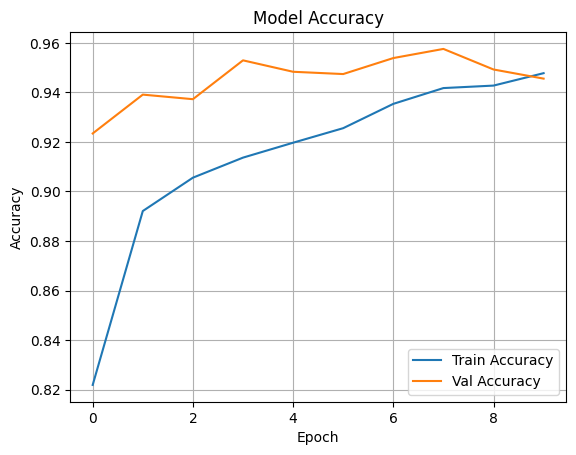

In [55]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

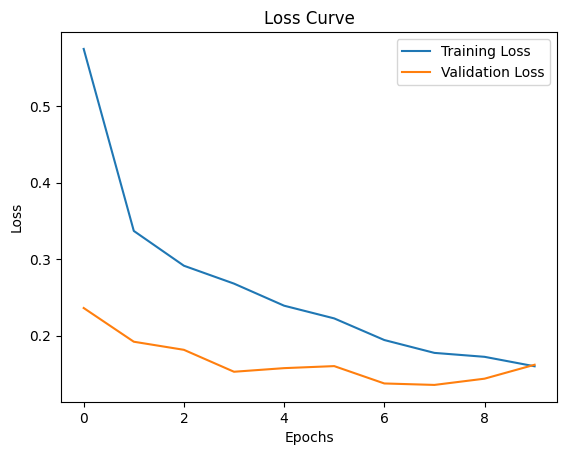

In [56]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step


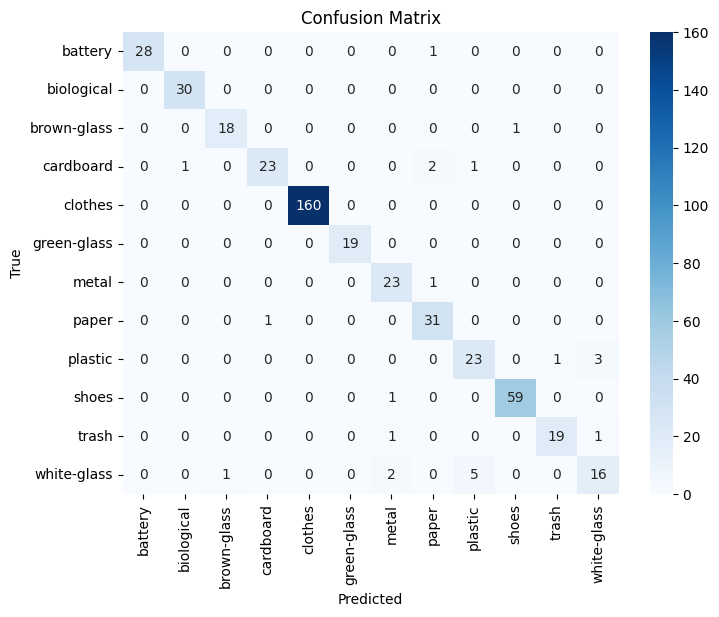

In [57]:
# Confusion Matrix
y_pred = model_tfl.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Hasil Evaluasi:**



1.   Score Accuracy
      *   Test Loss = 0.1695 (Rendah). Ini berarti prediksi model stabil dan jarang membuat kesalahan prediksi besar.
      *   Test Accuracy = 95.13% (Tinggi). Ini berarti model mampu generalisasi ke data baru dengan sangat baik.
      *  accuracy: 96.68% . Ini menunjukkan minor gap antara validasi dan Test yang mengindikasikan performa model lumayan konsisten. Ini juga menunjukkan tidak adanya indikasi overfitting.

2.   Accuracy Curve
      *   Training accuracy (Garis Biru) mengalami peningkatan terus menerus seiring epoch, ini berarti model belajar dengan baik dan tidak gagal memahami data.
      *   Validation accuracy (Garis Orange) langsung tinggi diawal yaitu sekitar 92% dan stabil di angka 94%-96%. Awal yang tinggi menunjukkan bahwa data cukup mudah untuk dipelajari.
      *   Berdasarkan jarak antara Training accuracy dan validation accuracy menunjukkan tidak adanya tanda overfitting yang parah.
3.   Loss Curve
      *   Training loss (Garis Biru) turun stabil seiring bertambahnya epoch, ini berarti model belajar dengan baik dari data training
      *   Validation loss (Garis Orange) selalu lebih rendah dari training loss (garis biru) dan latif stabil, ini berarti tidak ada overfitting.

4.   Confusion matrix
      *   Dari matrix yang ditampilkan menunjukkan model yang dihasilkan cukup baik dalam memprediksikan gambar dengan tepat. Masih terdapat beberapa kekeliruan, tetapi terdapat kelas yang diprediksi dengan akurasi tinggi yaitu biological, green-glass, dan clothes.
      *   Kekeliruan yang masih terjadi misalnya pada data white-glass yang masih sering dikira paper dan plasstic (lihat pada matriks, nilai: 2 dan 5). trash kadang dikira paper atau plastic. Sehingga Ini mengindikasikan bahwa fitur-fitur dari trash, white-glass, plastic, dan paper mungkin mirip satu sama lain di mata model.
      *   Kebanyakan kesalahan hasil prediksi dalam jumlah 1-5 perkelas, ini menunjukkan bahwa error tidak dominan dan model masih stabil.

## Konversi Model

Tahapan ini bertujuan untuk melakukan konversi terhadap model yang telah dilatih dan dievaluasi pada tahapan sebelumnya. Tahapan ini berguna agar model ayng telah dihasilkan dapat digunakan di berbagai perangkat.

Model klasifikasi gambar jenis sampah akan dibuat ke dalam 3 format antara lain:

1.   SavedModel
2.   TF-Lite dan
3.   TFJS




SavedModel

In [60]:
model_tfl.export('saved_model')

print("Yeay, Model berhasil disimpan ke format SavedModel!")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_337')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  136638753186704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753185744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753186128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753185936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753187856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753190736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753191120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753191504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753191312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136638753182480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13663875319265

In [65]:
# kompres SavedModel ke ZIP
shutil.make_archive('saved_model', 'zip', 'saved_model')

# unduh ZIP  ke perangkat
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TFLite

In [66]:
# Load SavedModel dan konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan file TFLite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite!")

Model berhasil dikonversi ke TFLite!


In [68]:
with open('label.txt', 'w') as f:
    for label in classes:
        f.write(label + '\n')

print("File label.txt berhasil dibuat!")

File label.txt berhasil dibuat!


In [67]:
# download model tflite dan label
files.download('model.tflite')
files.download('label.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
# TFJS

# instal tensorflowjs terlebih dahulu
# !pip install tensorflowjs

import tensorflowjs as tfjs

# Export ke folder tfjs_model
tfjs.converters.save_keras_model(model_tfl, 'tfjs_model')

print("Model berhasil dikonversi ke format TensorFlow.js!")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke format TensorFlow.js!


In [71]:
# kompres tfjs ke ZIP
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

# Unduh ZIP ke perangkat
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

Tahapan ini bertujuan untuk melakukan inferensi terhadap model yang telah dikonversi sebelumnya. Inference akan memastikan apakah model telah benar-benar mampu melakukan klasifikasi pada gambar yang diberikan. Pada proses ini saya akan menggunakan model format SavedModel untuk memperediksi gambar yang telah diuplaod menggunakan pengguna ke notebook ini.

Langkah pembuatan Inference yaitu:


1.   Upload Gambar dengan library files dari google colab
2.   Preprocessing gambar yang telah di-upload
3.   Melakukan prediksi dan Menampilkan hasilnya



In [79]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Image 2025-04-27 at 16.39.59.jpeg to WhatsApp Image 2025-04-27 at 16.39.59.jpeg


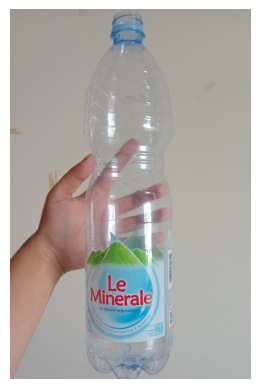

In [80]:
image_path = next(iter(uploaded))  # Ambil nama file pertama

image = Image.open(io.BytesIO(uploaded[image_path]))
plt.imshow(image)
plt.axis('off')
plt.show()

In [85]:
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi
predictions = model_tfl.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(f"Kelas hasil prediksi: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Kelas hasil prediksi: [8]


In [86]:
# mapping index ke nama label
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
print(f"Hasil Prediksi: {class_labels[predicted_class[0]]}")

Hasil Prediksi: plastic


In [87]:
!pip freeze > requirements.txt